In [4]:
import gym

import numpy as np
import matplotlib.pyplot as plt

In [159]:
WALL = 2
TAIL = 1
HEAD = 4
EMPTY = 0
APPLE = 3

LEFT = 0
FORWARD = 1
RIGHT = 2

class Board:
    """
    Describes the board of the game.
    
    Args:
        shape: tuple of ints
    """
    def __init__(self, shape=(12,12)):
        self.shape = shape
        self.board = np.zeros(self.shape, dtype=int)
        self.apple = None
        
        self._prepare_borders()
        
        self.snakes = []
        
    def _prepare_borders(self):
        """Creates the walls of the board."""
        self.board[:,0]  = WALL
        self.board[:,-1] = WALL
        self.board[0,:]  = WALL
        self.board[-1,:] = WALL
        
    def _reset_snakes(self):
        """Removes all snake fields from the board."""
        self.board[self.board == TAIL] = EMPTY # Clear tails
        self.board[self.board == HEAD] = EMPTY # Clear heads
        
    def _put_snakes(self):
        """
        Puts all the snakes on the board.
        """
        self._reset_snakes()
        
        for snake in self.snakes:
            for pos in snake.body:
                self.board[pos[0], pos[1]] = TAIL
            head = snake.body[-1]
            self.board[head[0], head[1]] = HEAD
            
                
    def _generate_apple(self):
        """Puts an apple on an empty field. To be changed to something more efficient."""
        # simple implementation
        self._remove_apple()
        self._put_snakes()
        valid_fields = np.argwhere(self.board == EMPTY)
        
        index = np.random.randint(valid_fields.shape[0])
        x, y = valid_fields[index]
        
        self.board[x, y] = APPLE
        self.apple = (x, y)
        
    def _remove_apple(self):
        self.board[self.board == APPLE] = EMPTY
        self.apple = None
        
    def show(self, mode='graphic'):
        if mode == 'text':
            for row in self.board:
                print(row)
        elif mode == 'graphic':
            plt.imshow(self.board)
            plt.show()
            
            
class Snake:
    """
    No step on snek.
    """
    def __init__(self, board, starting_position=None, starting_orientation=3, starting_length=3):
        self.board = board
        self.board.snakes.append(self) # Make the board track the snake
        
        if starting_position is None:
            starting_position = tuple(map(lambda x: x//2, board.shape))
            
        self.position = np.array(starting_position) # 2-tuple of ints
        self.orientation = starting_orientation # 0: down, 1: left, 2: up, 3: right
        
        self.converter = {
            0: np.array([1, 0]),
            1: np.array([0, -1]),
            2: np.array([-1, 0]),
            3: np.array([0, 1]),
        }
        
        self.body = [self.position - 2*self.converter[self.orientation], 
                     self.position - 1*self.converter[self.orientation], 
                     self.position - 0*self.converter[self.orientation]]
        
        self.body = list(map(tuple, self.body))
        
        self.fed = False
        
    def move(self):
        self.position = self.position + self.converter[self.orientation]
        self.body.append(tuple(self.position))
        if self.fed:
            self.fed = False
        else:
            self.body.pop(0)
        
    def __str__(self):
        return "Snake at " + str(self.position)
    
    def __repr__(self):
        return "Snake at " + str(self.position)
        

class Snake1PEnv(gym.Env):
    """
    Environment for a 1-Player Snake game. 
    """
    metadata = { 'render.modes': ['human'] }

    def __init__(self, board_shape=(12, 12)):
        self.board_shape = board_shape
        self.info = {}
        self._reset()

    def _reset(self):
        self.board = Board(self.board_shape)
        self.snake = Snake(self.board)
        self.reward = 0
        self.done = False
         
        self.board._generate_apple()
        
        return self.board

    def _step(self, action):
        assert action in (0, 1, 2) # 0: turn left, 1: don't turn, 2: turn right
        action = action - 1 
        
        self.snake.orientation = (self.snake.orientation + action) % 4
    
        self.snake.move()
        
        self.board._put_snakes()
        
        x, y = self.snake.position
        
        # Check for wall and tail collision
        if self.board.board[x, y] in (WALL, TAIL):
            self.done = True

        # Check for apples
        if (x, y) == self.board.apple:
            self.snake.fed = True
            self.reward += 1
            self.board._generate_apple()
            

        return self.board, self.reward, self.done, self.info

    def _render(self, mode='human', close=False):
        plt.imshow(self.board.board)
        plt.show()

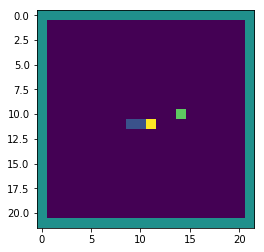

In [150]:
game = Snake1PEnv(board_shape=(22,22))

game._render()

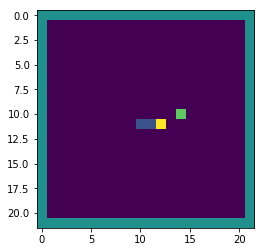

In [152]:
game._step(FORWARD)
game._render()

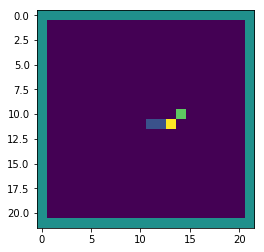

In [153]:
game._step(FORWARD)
game._render()

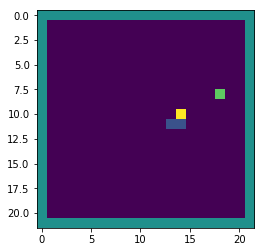

In [155]:
game._step(LEFT)
game._render()

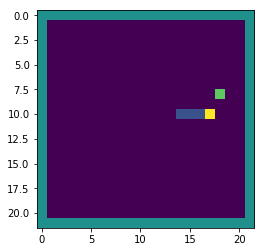

In [158]:
game._step(FORWARD)
game._render()